year       int64
month      int64
meant    float64
maxtp    float64
mintp    float64
mnmax    float64
mnmin    float64
rain     float64
gmin      object
wdsp      object
maxgt     object
sun       object
dtype: object


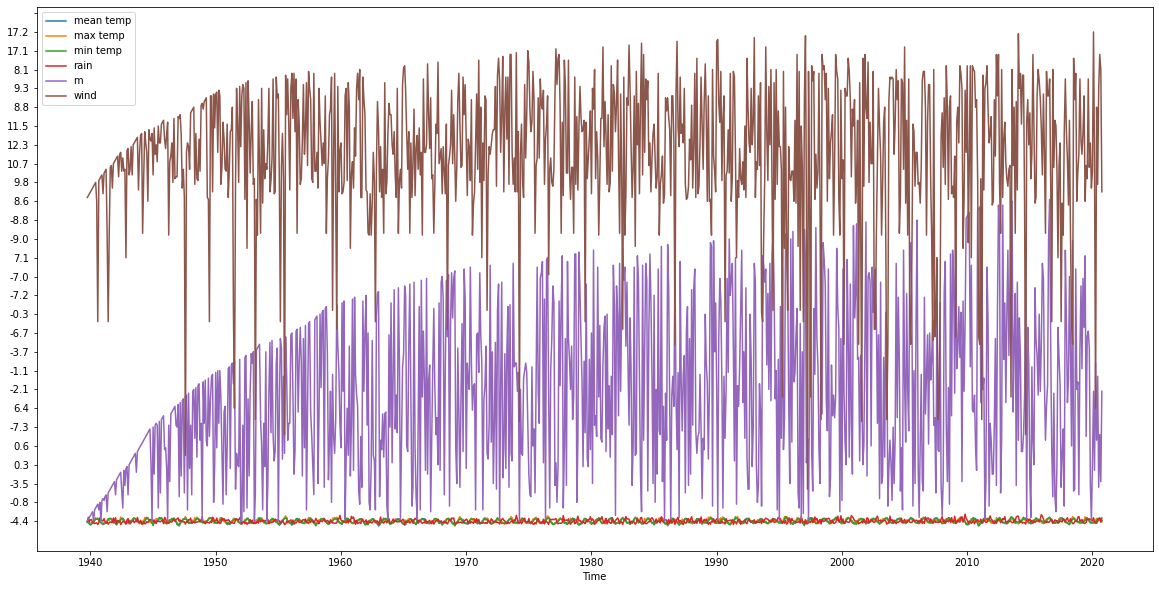

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime


#download data, organize into arrays

df = pd.read_csv("mly2275.csv", comment='#')
#print(df.head())
print(df.dtypes) #some of our columns came out as 'object' (string)
pd.to_numeric(df.gmin, errors='ignore')
y1=df.iloc[:, 0]
y2=df.iloc[:, 1]

#making y an array of dates 
y=[]
for i in range(np.size(y1, 0)):
    y.append(datetime.date(y1[i], y2[i], 1))
y=np.array(y)

X1=df.iloc[:, 2]
X2=df.iloc[:, 3]
X3=df.iloc[:, 4]
X4=df.iloc[:, 5]
X5=df.iloc[:, 6]
X6=df.iloc[:, 7]
X7=df.iloc[:, 8] # for some reason, this column seems to be stored as strings, so convert that
X8=df.iloc[:, 9]
X9=df.iloc[:, 10]
X10=df.iloc[:, 11]
X=np.column_stack((X1, X2, X3, X4, X5, X6, X7, X8, X9, X10))
#normalize the data
X1 = np.divide((X1-X1.mean()), np.std(X1))
X2 = np.divide((X2-X2.mean()), np.std(X2))
X3 = np.divide((X3-X3.mean()), np.std(X3))
X4 = np.divide((X4-X4.mean()), np.std(X4))
X5 = np.divide((X5-X5.mean()), np.std(X5))
X6 = np.divide((X6-X6.mean()), np.std(X6))
#X7 = np.divide((X7-X7.mean()), np.std(X7))
#X8 = np.divide((X8-X8.mean()), np.std(X8))
#X9 = np.divide((X9-X9.mean()), np.std(X9))
#X10 = np.divide((X10-X10.mean()), np.std(X10))

#visualise data

#timeline

f=plt.figure()
f.set_figwidth(20) 
f.set_figheight(10) 
plt.xlabel('Time')
plt.yticks(np.arange(0, 300, 10))
plt.yticks()
plt.plot(y, X1, label='mean temp')
plt.plot(y, X2, label='max temp')
plt.plot(y, X3, label='min temp')
#plt.plot(y, X4)
#plt.plot(y, X5)
plt.plot(y, X6, label='rain')
plt.plot(y, X7, label='m')
plt.plot(y, X8, label='wind')
#plt.plot(y, X9)
#plt.plot(y, X10, label='sun') #note that sun data disappears around 2010 - 2015
plt.legend()
plt.show()

In [ ]:
C = [0.1, 1, 10]
for c in C:
    